In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import typing as t
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm.notebook import tqdm
from IPython.display import HTML
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize


In [2]:
data_folder = "/home/gleb_galagan/tbank_recsys/sirius_recsys/sirius-2025-recsys/data/"

In [3]:
train = pl.read_parquet(data_folder + "train.pq")
print("Train:")
print(train.shape)
display(train.head(5))

Train:
(11971437, 5)


user_id,item_id,is_read,rating,date_added
str,i64,bool,i64,datetime[μs]
"""90998a29029ecb1fbeedaff2b71752…",8473,false,0,2014-05-15 12:51:13
"""90998a29029ecb1fbeedaff2b71752…",20060,false,0,2014-05-15 12:51:14
"""90998a29029ecb1fbeedaff2b71752…",8354,false,0,2014-05-15 12:51:17
"""90998a29029ecb1fbeedaff2b71752…",11575,false,0,2014-05-15 12:51:19
"""90998a29029ecb1fbeedaff2b71752…",11861,false,0,2014-05-15 12:51:20


In [4]:
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))
print("Test:")
print(test.shape)
display(test.head(5))

Test:
(185828, 2)


user_id,item_id
str,list[i64]
"""00000377eea48021d3002730d56aca…",[13252]
"""00009ab2ed8cbfceda5a59da409663…",[2328]
"""00009e46d18f223a82b22da38586b6…","[28636, 30197]"
"""0001085188e302fc6b2568de45a5f5…","[2159, 2969, … 33630]"
"""00014c578111090720e20f5705eba0…","[45, 3513, … 33273]"


In [5]:
books = pl.read_parquet(data_folder + "books.pq")
print("Books:")
print(books.shape)
display(books.head(5))

Books:
(34322, 8)


item_id,series,tags,title,description,url,image_url,authors
i64,list[str],list[str],str,str,str,str,list[struct[2]]
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]"
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]"


## EDA

In [ ]:
books_cleaned = books.with_columns(
    pl.col('series').replace([None], 0).alias('series')
)
# books_cleaned.head(5)

item_id,series,tags,title,description,url,image_url,authors
i64,list[str],list[str],str,str,str,str,list[struct[2]]
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]"
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]"
…,…,…,…,…,…,…,…
34317,"[""849421""]","[""will-never-read"", ""action"", … ""fiction""]","""The Cruelty (The Cruelty, #1)""","""When her diplomat father is ki…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14713542"",""""}]"
34318,"[""795937""]","[""haven-t-bothered-to-finish"", ""library"", … ""favorites""]","""Does Snogging Count as Exercis…","""As one of the only girls in Ye…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""753459"",""""}]"
34319,"[""921523""]","[""young-adult"", ""200-299-pgs"", … ""i-don-t-know""]","""Discovery (The Gifted, #1)""","""All twenty-three year old Kate…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14590184"",""""}]"


In [ ]:
books_cleaned = books.with_columns(
    pl.when(
        (pl.col('series').list.len() == 1) & (pl.col('series').list.first().is_null())
    )
    .then(pl.lit(["0"], dtype=pl.List(pl.Utf8)))
    .otherwise(pl.col('series'))
    .alias('series')
)
books_cleaned.head(5)

In [9]:
# Calculate the length of each list in the 'series' column
books_with_length = books.with_columns(
    pl.col('series').list.len().alias('series_length')
)

# Find the maximum length
max_length = books_with_length['series_length'].max()

# Filter rows where the list length equals the maximum length
longest_series = books_with_length.filter(
    pl.col('series_length') == max_length
)

# Select relevant columns and display
result = longest_series.select(['item_id', 'series', 'series_length', 'title'])
print(result)

shape: (2, 4)
┌─────────┬─────────────────────────────────┬───────────────┬────────────┐
│ item_id ┆ series                          ┆ series_length ┆ title      │
│ ---     ┆ ---                             ┆ ---           ┆ ---        │
│ i64     ┆ list[str]                       ┆ u64           ┆ str        │
╞═════════╪═════════════════════════════════╪═══════════════╪════════════╡
│ 17220   ┆ ["832282", "1127812", … null]   ┆ 5             ┆ Unleashed  │
│ 19144   ┆ ["824774", "291336", … "558673… ┆ 5             ┆ Mind Games │
└─────────┴─────────────────────────────────┴───────────────┴────────────┘


In [ ]:
books_with_length.sort(by='series_length').head(5)

item_id,series,tags,title,description,url,image_url,authors,series_length
i64,list[str],list[str],str,str,str,str,list[struct[2]],u64
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]",1
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]",1
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]",1
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]",1
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]",1
…,…,…,…,…,…,…,…,…
32927,"[""1135762"", ""1135766"", … ""300214""]","[""no-longer-own"", ""want"", … ""on-my-shelf""]","""Timestorm (Tempest, #3)""","""The battle between the Tempest…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""3429117"",""""}]",4
33230,"[""964041"", ""265145"", … ""409278""]","[""currently-reading"", ""buffy-books"", … ""vamps""]","""Halloween Rain (Buffy the Vamp…","""Around Sunnydale, they say a s…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""4522"",""""}, {""27206"",""""}]",4
34218,"[""148726"", ""824020"", … ""824067""]","[""fiction"", ""favorites"", … ""read-in-2014""]","""The Struggle""","""A Love Triangle of Unspeakable…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""50873"",""""}]",4


# EDA interactions

Анализируем интеракции юзеров и книг

In [ ]:
train.head(5)

user_id,item_id,is_read,rating,date_added
str,i64,bool,i64,datetime[μs]
"""90998a29029ecb1fbeedaff2b71752…",8473,false,0,2014-05-15 12:51:13
"""90998a29029ecb1fbeedaff2b71752…",20060,false,0,2014-05-15 12:51:14
"""90998a29029ecb1fbeedaff2b71752…",8354,false,0,2014-05-15 12:51:17
"""90998a29029ecb1fbeedaff2b71752…",11575,false,0,2014-05-15 12:51:19
"""90998a29029ecb1fbeedaff2b71752…",11861,false,0,2014-05-15 12:51:20
…,…,…,…,…
"""41b6ce17e6716721ba0a3364730d60…",12298,false,0,2016-12-10 02:45:58
"""31afc6f51ab44c5f886dbfa497c241…",6273,false,0,2016-12-10 02:45:59
"""cff0631d0dae40675e525f008aac1d…",960,true,5,2016-12-10 02:46:10


Также у нас есть бинарная фича is_read, мы можем перевести is_read в 0 и 1

In [13]:
# Convert is_read from boolean to integer (true -> 1, false -> 0)
train = train.with_columns(
    pl.col('is_read').cast(pl.Int8).alias('is_read')
)
train.select('is_read').to_series().describe()

statistic,value
str,f64
"""count""",1.1971437e7
"""null_count""",0.0
"""mean""",0.391888
"""std""",0.488172
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",1.0
"""max""",1.0


In [14]:
train.describe()

statistic,user_id,item_id,is_read,rating,date_added
str,str,f64,f64,f64,str
"""count""","""11971437""",1.1971437e7,1.1971437e7,1.1971437e7,"""11971437"""
"""null_count""","""0""",0.0,0.0,0.0,"""0"""
"""mean""",null,16913.768205,0.391888,1.432679,"""2015-08-27 03:50:02.012039"""
"""std""",null,9950.337952,0.488172,1.997666,null
"""min""","""00000377eea48021d3002730d56aca…",0.0,0.0,0.0,"""2014-05-15 12:51:13"""
"""25%""",null,8303.0,0.0,0.0,"""2015-01-10 06:50:53"""
"""50%""",null,16739.0,0.0,0.0,"""2015-08-31 04:22:39"""
"""75%""",null,25849.0,1.0,4.0,"""2016-04-08 13:04:47"""
"""max""","""fffff8a718843c0e11dfd93fb41c12…",34321.0,1.0,5.0,"""2016-12-10 02:46:36"""


In [15]:
train

user_id,item_id,is_read,rating,date_added
str,i64,i8,i64,datetime[μs]
"""90998a29029ecb1fbeedaff2b71752…",8473,0,0,2014-05-15 12:51:13
"""90998a29029ecb1fbeedaff2b71752…",20060,0,0,2014-05-15 12:51:14
"""90998a29029ecb1fbeedaff2b71752…",8354,0,0,2014-05-15 12:51:17
"""90998a29029ecb1fbeedaff2b71752…",11575,0,0,2014-05-15 12:51:19
"""90998a29029ecb1fbeedaff2b71752…",11861,0,0,2014-05-15 12:51:20
…,…,…,…,…
"""41b6ce17e6716721ba0a3364730d60…",12298,0,0,2016-12-10 02:45:58
"""31afc6f51ab44c5f886dbfa497c241…",6273,0,0,2016-12-10 02:45:59
"""cff0631d0dae40675e525f008aac1d…",960,1,5,2016-12-10 02:46:10


In [16]:
train.group_by('item_id').agg(pl.count().alias('count')).sort(by='count', descending=True)

/tmp/ipykernel_1960/2978319012.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  train.group_by('item_id').agg(pl.count().alias('count')).sort(by='count', descending=True)


item_id,count
i64,u64
4058,91558
15514,88038
18150,76860
30197,65033
33370,59835
…,…
14788,1
6258,1
32220,1


/tmp/ipykernel_1960/830197745.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  count_data = train.group_by('item_id').agg(pl.count().alias('count')).sort(by='count', descending=True)


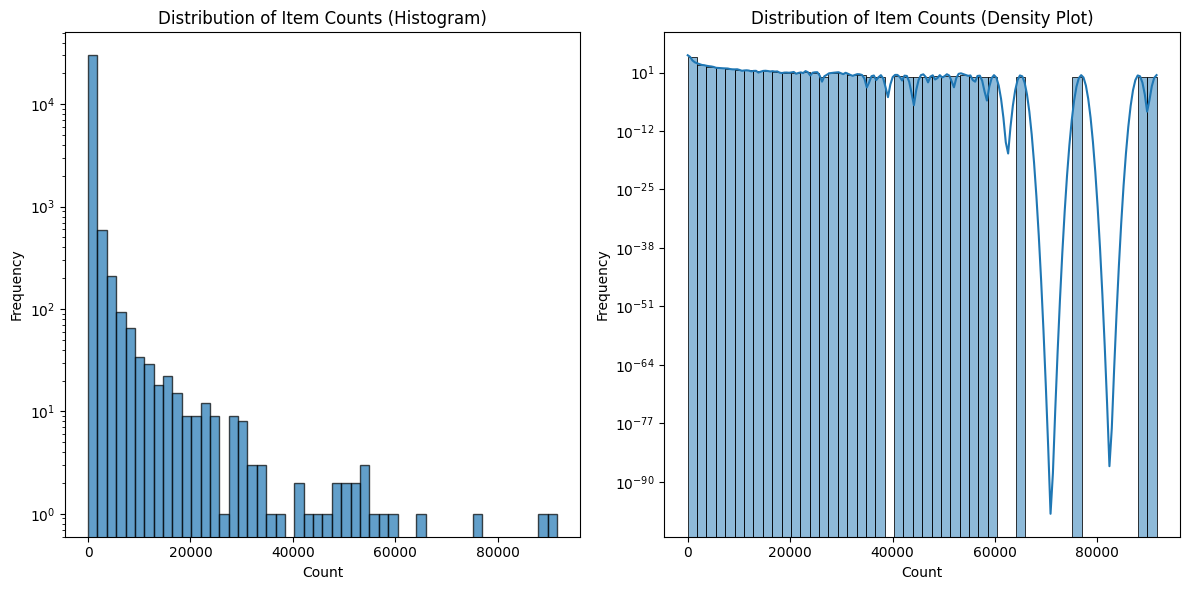

In [17]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the count data
count_data = train.group_by('item_id').agg(pl.count().alias('count')).sort(by='count', descending=True)

# Convert to pandas for plotting (or extract to numpy array)
counts = count_data['count'].to_numpy()

# Create the distribution plot
plt.figure(figsize=(12, 6))

# Option 1: Histogram
plt.subplot(1, 2, 1)
plt.hist(counts, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Item Counts (Histogram)')
plt.yscale('log')  # Log scale for better visualization

# Option 2: Density plot using seaborn
plt.subplot(1, 2, 2)
sns.histplot(counts, kde=True, bins=50)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Item Counts (Density Plot)')
plt.yscale('log')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1960/511363789.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  count_data = train.group_by('user_id').agg(pl.count().alias('count')).sort(by='count', descending=True)


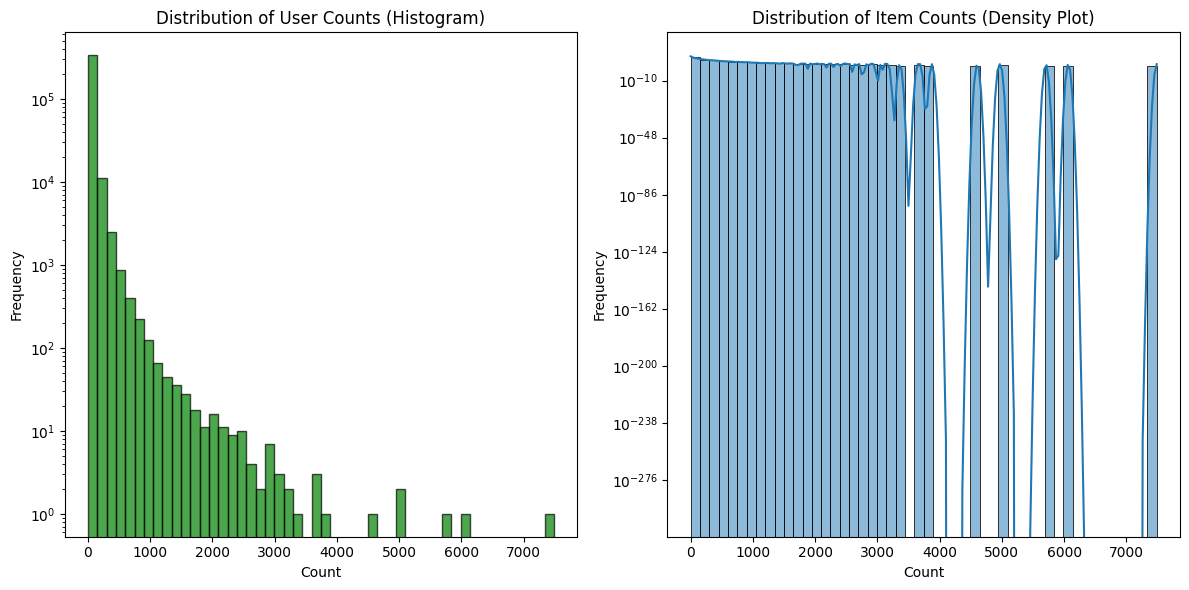

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the count data
count_data = train.group_by('user_id').agg(pl.count().alias('count')).sort(by='count', descending=True)

# Convert to pandas for plotting (or extract to numpy array)
counts = count_data['count'].to_numpy()

# Create the distribution plot
plt.figure(figsize=(12, 6))

# Option 1: Histogram
plt.subplot(1, 2, 1)
plt.hist(counts, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of User Counts (Histogram)')
plt.yscale('log')  # Log scale for better visualization

# Option 2: Density plot using seaborn
plt.subplot(1, 2, 2)
sns.histplot(counts, kde=True, bins=50)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Item Counts (Density Plot)')
plt.yscale('log')

plt.tight_layout()
plt.show()

**Как я понимаю интеракции тут** есть взаимодействие юзера и книги, по видимому добавление (тк у нас тут именно date added по которрой идет сортировка), есть поле is_read прочитано или нет, вопрос этим же юзером или нет(если этим то зачем добавлять, если в целом то почему так много непрочитанных книг на сервисе, но с другой стороны у нас же вопрос про холодные айтемы и таких 60%) 


#### Is read

In [19]:
is_read_list = train.select('is_read').to_series().value_counts()
is_read_list.with_columns((pl.col('count')/train.shape[0]).alias('percentage'))

is_read,count,percentage
i8,u64,f64
0,7279978,0.608112
1,4691459,0.391888


Во время 60% интеракций книга была прочитана юзером. Т.е. is_read это хороший позитивный сигнал

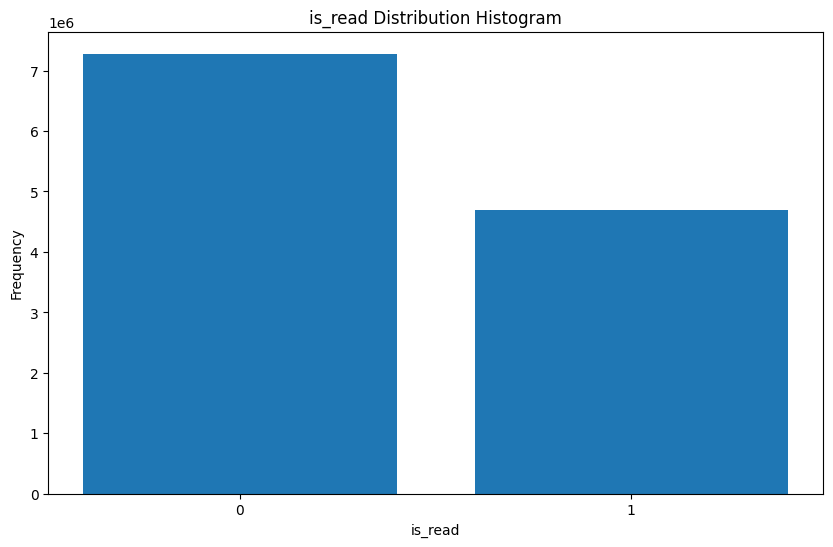

shape: (2, 2)
┌─────────┬─────────┐
│ is_read ┆ count   │
│ ---     ┆ ---     │
│ i8      ┆ u64     │
╞═════════╪═════════╡
│ 0       ┆ 7279978 │
│ 1       ┆ 4691459 │
└─────────┴─────────┘


In [20]:
import matplotlib.pyplot as plt

# Get the data
hist_data = (
    train
    .get_column('is_read')
    .value_counts()
    .sort('is_read')
)

is_read = hist_data.select('is_read').to_series().to_list()
frequencies = hist_data.select('count').to_series().to_list()

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(is_read, frequencies)
plt.xlabel('is_read')
plt.ylabel('Frequency')
plt.title('is_read Distribution Histogram')
plt.xticks(is_read)  # Show all rating values on x-axis
plt.show()

print(hist_data)

#### rating

Смотрим на фичу рейтинг. Видим что у нас 5 балльная шкала по рейтингу. Большая часть оценок хорошие 75% перцентиль - 4,  

**Считаем моду**


In [21]:
train.select('rating').to_series().describe()


statistic,value
str,f64
"""count""",1.1971437e7
"""null_count""",0.0
"""mean""",1.432679
"""std""",1.997666
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",4.0
"""max""",5.0


In [22]:
rating_list = train.select('rating').to_series().value_counts()
rating_list.with_columns((pl.col('count')/train.shape[0]).alias('percentage')).sort(by='count', descending=True)

rating,count,percentage
i64,u64,f64
0,7649845,0.639008
5,1551182,0.129574
4,1517959,0.126798
3,906917,0.075757
2,257190,0.021484
1,88344,0.00738


Самое большое количество интеракций где книге не поставили оценку, далее чуть меннее популярное оценка 5 и 4, низкие оценки не так популярны

**Смотрим на распределение рейтинга**


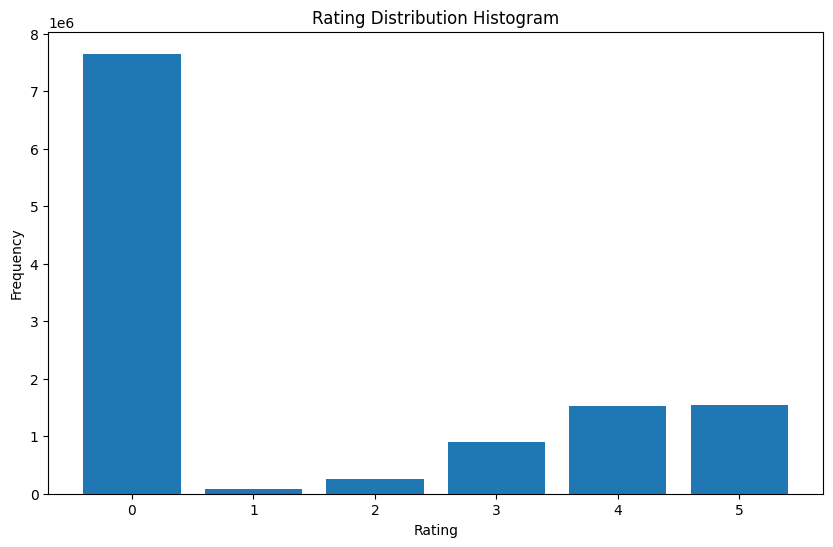

shape: (6, 2)
┌────────┬─────────┐
│ rating ┆ count   │
│ ---    ┆ ---     │
│ i64    ┆ u64     │
╞════════╪═════════╡
│ 0      ┆ 7649845 │
│ 1      ┆ 88344   │
│ 2      ┆ 257190  │
│ 3      ┆ 906917  │
│ 4      ┆ 1517959 │
│ 5      ┆ 1551182 │
└────────┴─────────┘


In [23]:
import matplotlib.pyplot as plt

# Get the data
hist_data = (
    train
    .get_column('rating')
    .value_counts()
    .sort('rating')
)

ratings = hist_data.select('rating').to_series().to_list()
frequencies = hist_data.select('count').to_series().to_list()

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(ratings, frequencies)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution Histogram')
plt.xticks(ratings)  # Show all rating values on x-axis
plt.show()

print(hist_data)

Видим что большая часть интеракций с книгаме не сопряжена с оценками (либо книгу не дочитали, либо просто не поставили оценку). Возможно юзеры не такие активные. Однако в целом оценки положительные, наиболее популярна оценка 4

**Смотрим на взаимотношение и закономерности с этими фичами**

In [24]:
# Create a cross-tabulation to see the relationship
cross_tab = (
    train
    .group_by(['is_read', 'rating'])
    .agg(pl.count().alias('count'))
    .sort(['is_read', 'rating'])
)

print("Cross-tabulation of is_read vs rating:")
print(cross_tab)

Cross-tabulation of is_read vs rating:
shape: (7, 3)
┌─────────┬────────┬─────────┐
│ is_read ┆ rating ┆ count   │
│ ---     ┆ ---    ┆ ---     │
│ i8      ┆ i64    ┆ u64     │
╞═════════╪════════╪═════════╡
│ 0       ┆ 0      ┆ 7279978 │
│ 1       ┆ 0      ┆ 369867  │
│ 1       ┆ 1      ┆ 88344   │
│ 1       ┆ 2      ┆ 257190  │
│ 1       ┆ 3      ┆ 906917  │
│ 1       ┆ 4      ┆ 1517959 │
│ 1       ┆ 5      ┆ 1551182 │
└─────────┴────────┴─────────┘


/tmp/ipykernel_1960/4126475056.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias('count'))


Как и ожидалось большая часть нулей как раз из за того что книга была не прочитана

In [25]:
# Compare rating distributions for read vs not-read items
rating_stats_by_read = (
    train
    .group_by('is_read')
    .agg(
        pl.count().alias('total_count'),
        pl.mean('rating').round(2).alias('avg_rating'),
        pl.median('rating').alias('median_rating'),
        pl.std('rating').round(2).alias('std_rating'),
        pl.min('rating').alias('min_rating'),
        pl.max('rating').alias('max_rating')
    )
)

print("Rating statistics by is_read status:")
print(rating_stats_by_read)

/tmp/ipykernel_1960/2324486685.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('total_count'),


Rating statistics by is_read status:
shape: (2, 7)
┌─────────┬─────────────┬────────────┬───────────────┬────────────┬────────────┬────────────┐
│ is_read ┆ total_count ┆ avg_rating ┆ median_rating ┆ std_rating ┆ min_rating ┆ max_rating │
│ ---     ┆ ---         ┆ ---        ┆ ---           ┆ ---        ┆ ---        ┆ ---        │
│ i8      ┆ u64         ┆ f64        ┆ f64           ┆ f64        ┆ i64        ┆ i64        │
╞═════════╪═════════════╪════════════╪═══════════════╪════════════╪════════════╪════════════╡
│ 0       ┆ 7279978     ┆ 0.0        ┆ 0.0           ┆ 0.0        ┆ 0          ┆ 0          │
│ 1       ┆ 4691459     ┆ 3.66       ┆ 4.0           ┆ 1.43       ┆ 0          ┆ 5          │
└─────────┴─────────────┴────────────┴───────────────┴────────────┴────────────┴────────────┘


#### date_added

In [26]:
print(
    train.select(
        pl.col("date_added").min().alias("date_added_min"),
        pl.col("date_added").max().alias("date_added_max")
    )
)


shape: (1, 2)
┌─────────────────────┬─────────────────────┐
│ date_added_min      ┆ date_added_max      │
│ ---                 ┆ ---                 │
│ datetime[μs]        ┆ datetime[μs]        │
╞═════════════════════╪═════════════════════╡
│ 2014-05-15 12:51:13 ┆ 2016-12-10 02:46:36 │
└─────────────────────┴─────────────────────┘


Данные представлены за 2.5 года

In [27]:
date_train = train.with_columns(
    pl.col("date_added").dt.month().alias("month"),
    pl.col("date_added").dt.week().alias("week"),
    pl.col("date_added").dt.day().alias("day"),
    pl.col("date_added").dt.hour().alias("hour"),
    pl.col("date_added").dt.weekday().alias("weekday")  # 1 = Monday, 7 = Sunday
)


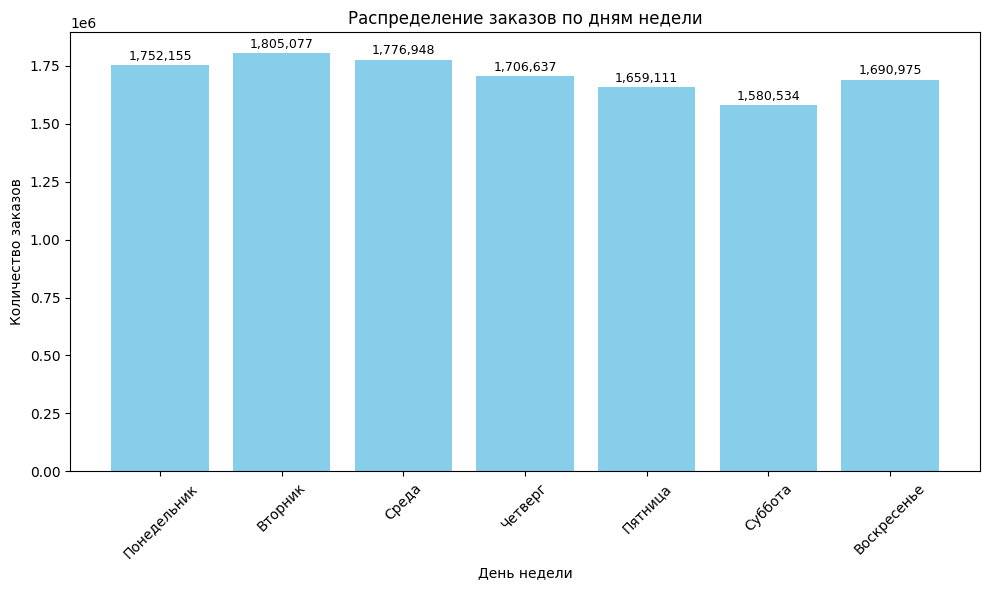

In [28]:
import matplotlib.pyplot as plt

# Get weekday counts
weekday_counts = date_train.select('weekday').to_series().value_counts().sort('weekday')

# Extract data for plotting
weekdays = weekday_counts['weekday'].to_list()
counts = weekday_counts['count'].to_list()

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(weekdays, counts, color='skyblue')

# Customize the plot
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов по дням недели')
plt.xticks(weekdays, ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'], rotation=45)

# Add value labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000, 
             f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Рассмотрим дни недели в которых были добавлены книги. Как видим мы имеем дело с равномерным распределением и существенного изменения активности связанного с днем недели нет.

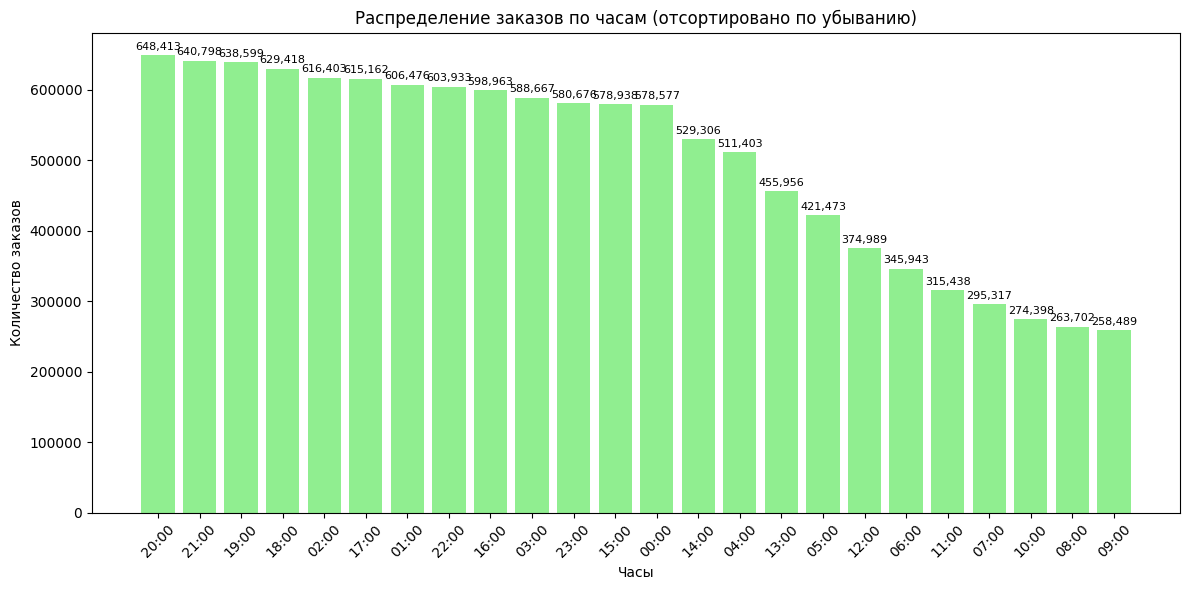

In [29]:
import matplotlib.pyplot as plt

# Get hour counts sorted by count (descending)
hour_counts = (date_train
               .select('hour')
               .to_series()
               .value_counts()
               .sort('count', descending=True))

# Extract data for plotting
hours = hour_counts['hour'].to_list()
counts = hour_counts['count'].to_list()

# Create bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(hours)), counts, color='lightgreen')

# Customize the plot
plt.xlabel('Часы')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов по часам (отсортировано по убыванию)')
plt.xticks(range(len(hours)), [f'{hour:02d}:00' for hour in hours], rotation=45)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'{count:,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Смотрим на время добавления книг. Наименьшее количество добавлено в начале рабочего дня и ранним утром. Наибольшее это вечер после рабочего дня

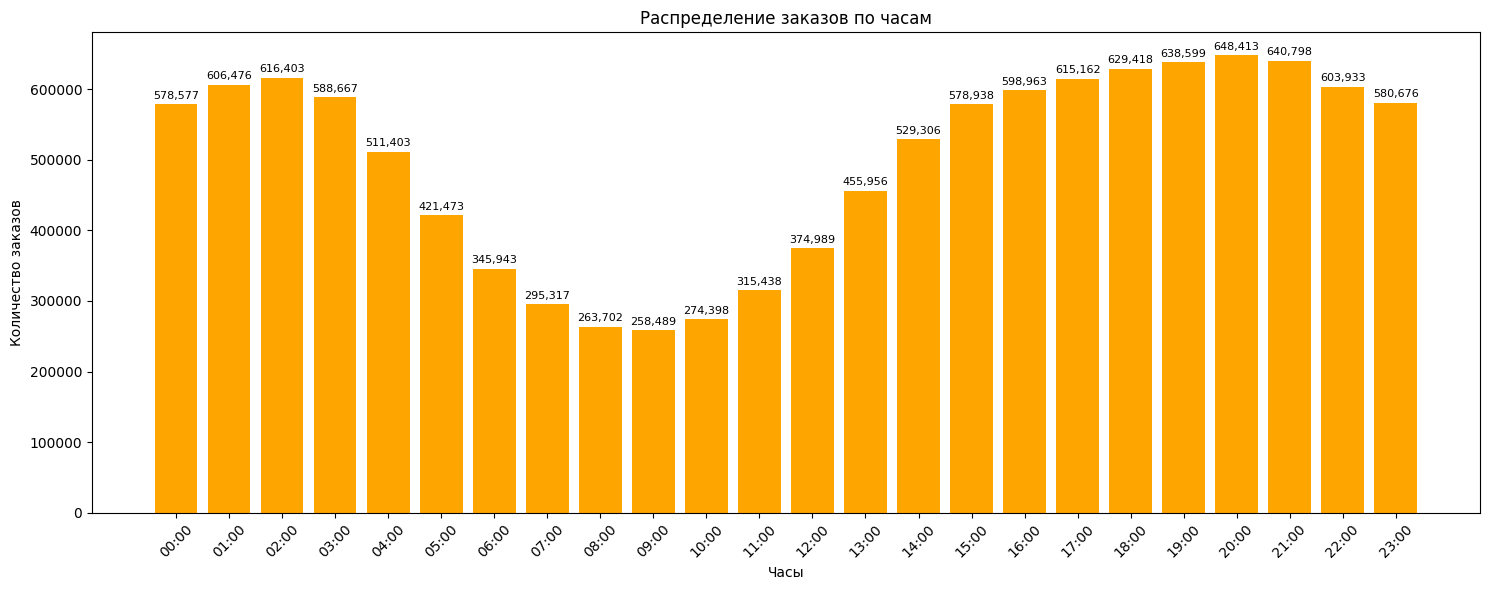

In [30]:
import matplotlib.pyplot as plt

# Get hour counts sorted by hour
hour_counts = (date_train
               .select('hour')
               .to_series()
               .value_counts()
               .sort('hour'))

# Extract data for plotting
hours = hour_counts['hour'].to_list()
counts = hour_counts['count'].to_list()

# Create bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(hours, counts, color='orange', width=0.8)

# Customize the plot
plt.xlabel('Часы')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов по часам')
plt.xticks(hours, [f'{hour:02d}:00' for hour in hours], rotation=45)

# Add value labels on bars
for hour, count in zip(hours, counts):
    plt.text(hour, count + 5000, f'{count:,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Аналогичный график без сортировки

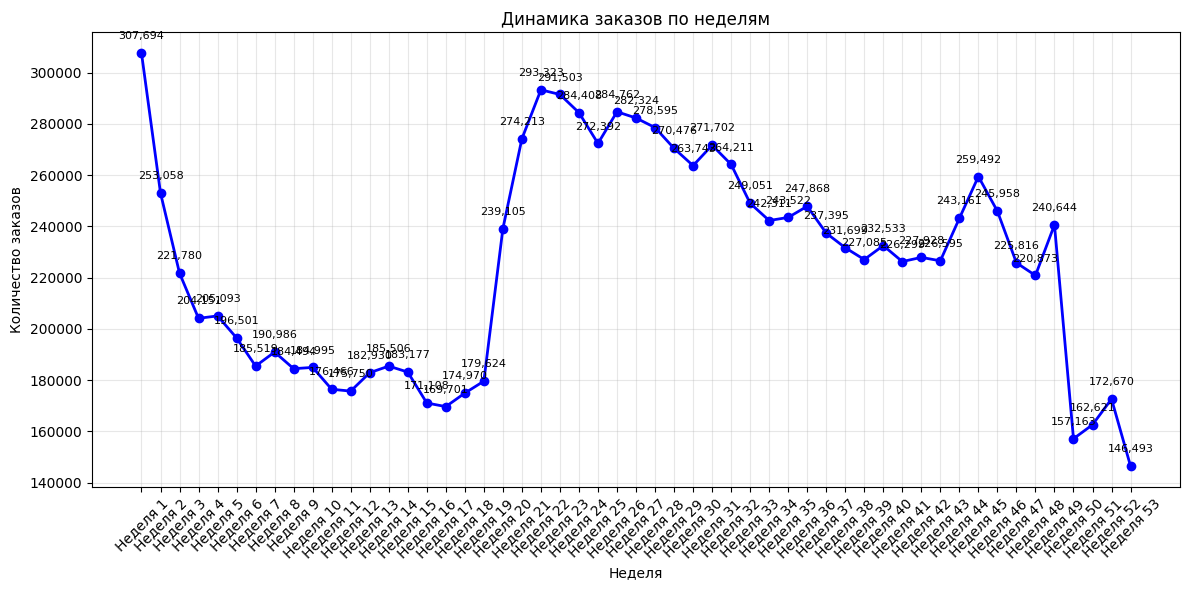

In [31]:
import matplotlib.pyplot as plt

# Get week counts sorted by week
week_counts = (date_train
               .select('week')
               .to_series()
               .value_counts()
               .sort('week'))

# Extract data for plotting
weeks = week_counts['week'].to_list()
counts = week_counts['count'].to_list()

# Create line plot
plt.figure(figsize=(12, 6))
plt.plot(weeks, counts, marker='o', linewidth=2, markersize=6, color='blue')

# Customize the plot
plt.xlabel('Неделя')
plt.ylabel('Количество заказов')
plt.title('Динамика заказов по неделям')
plt.grid(True, alpha=0.3)

# Add value labels on points
for week, count in zip(weeks, counts):
    plt.annotate(f'{count:,}', (week, count), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=8)

# Set x-axis ticks
plt.xticks(weeks, [f'Неделя {week}' for week in weeks], rotation=45)

plt.tight_layout()
plt.show()

Рассмотрим график по неделям, есть ли какая то цикличность. В целом график похож на случайный, закономерностей не наблюдается

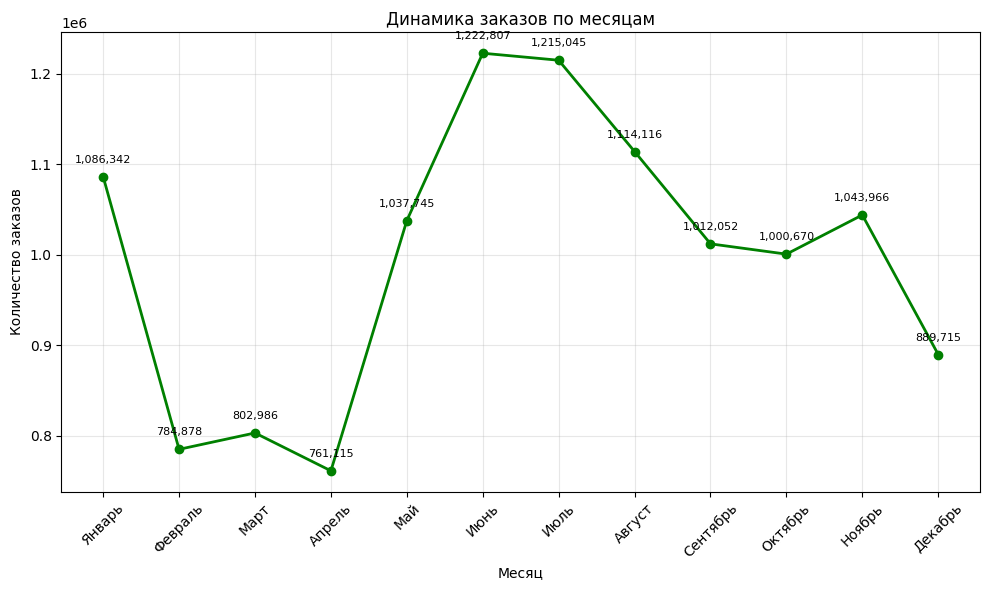

In [32]:
import matplotlib.pyplot as plt

# Get month counts sorted by month
month_counts = (date_train
               .select('month')
               .to_series()
               .value_counts()
               .sort('month'))

# Extract data for plotting
months = month_counts['month'].to_list()
counts = month_counts['count'].to_list()

# Create line plot
plt.figure(figsize=(10, 6))
plt.plot(months, counts, marker='o', linewidth=2, markersize=6, color='green')

# Customize the plot
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Динамика заказов по месяцам')
plt.grid(True, alpha=0.3)

# Add value labels on points
for month, count in zip(months, counts):
    plt.annotate(f'{count:,}', (month, count), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=8)

# Set x-axis ticks with month names
month_names = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 
               'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
plt.xticks(months, [month_names[m-1] for m in months], rotation=45)

plt.tight_layout()
plt.show()

Рассмотрим количество заказов по месяцам. Наибольшее количество заказов у нас летом и в январе (каникулы и отпуска)

# EDA Books

In [33]:
books_cleaned


item_id,series,tags,title,description,url,image_url,authors
i64,list[str],list[str],str,str,str,str,list[struct[2]]
0,"[""0""]","[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]"
2,"[""0""]","[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]"
…,…,…,…,…,…,…,…
34317,"[""849421""]","[""will-never-read"", ""action"", … ""fiction""]","""The Cruelty (The Cruelty, #1)""","""When her diplomat father is ki…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14713542"",""""}]"
34318,"[""795937""]","[""haven-t-bothered-to-finish"", ""library"", … ""favorites""]","""Does Snogging Count as Exercis…","""As one of the only girls in Ye…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""753459"",""""}]"
34319,"[""921523""]","[""young-adult"", ""200-299-pgs"", … ""i-don-t-know""]","""Discovery (The Gifted, #1)""","""All twenty-three year old Kate…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14590184"",""""}]"


In [34]:
books_cleaned.select('item_id').n_unique()

34322

In [35]:
train.select('item_id').n_unique()

31300

Почти 10% айтемов холодные

In [36]:
books_cleaned.describe()

statistic,item_id,series,tags,title,description,url,image_url,authors
str,f64,f64,f64,str,str,str,str,f64
"""count""",34322.0,34322.0,34322.0,"""34322""","""34322""","""34322""","""34322""",34322.0
"""null_count""",0.0,0.0,0.0,"""0""","""0""","""0""","""0""",0.0
"""mean""",17160.5,null,null,null,null,null,null,null
"""std""",9908.052306,null,null,null,null,null,null,null
"""min""",0.0,null,null,"""""B"" Is for Bad at Getting into…","""""","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…",null
"""25%""",8580.0,null,null,null,null,null,null,null
"""50%""",17161.0,null,null,null,null,null,null,null
"""75%""",25741.0,null,null,null,null,null,null,null
"""max""",34321.0,null,null,"""微微一笑很倾城 [Just One Smile Is Ver…","""~Tales of Ever is an action pa…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…",null


#### description

Здесь все понятно, берем текстовый энкодер и смотрим что и как. Смотрим Длину и смотрим языки

#### image_url

Здесь тоже все понятно берем визуальный энкодер и делаем

#### series

Фича Серии видимо представляет из себя количество книг в серии. Властелин Колец, Гарри Поттер, Игра Престолов и тд

In [37]:
books_with_length

item_id,series,tags,title,description,url,image_url,authors,series_length
i64,list[str],list[str],str,str,str,str,list[struct[2]],u64
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]",1
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]",1
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]",1
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]",1
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]",1
…,…,…,…,…,…,…,…,…
34317,"[""849421""]","[""will-never-read"", ""action"", … ""fiction""]","""The Cruelty (The Cruelty, #1)""","""When her diplomat father is ki…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14713542"",""""}]",1
34318,"[""795937""]","[""haven-t-bothered-to-finish"", ""library"", … ""favorites""]","""Does Snogging Count as Exercis…","""As one of the only girls in Ye…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""753459"",""""}]",1
34319,"[""921523""]","[""young-adult"", ""200-299-pgs"", … ""i-don-t-know""]","""Discovery (The Gifted, #1)""","""All twenty-three year old Kate…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14590184"",""""}]",1


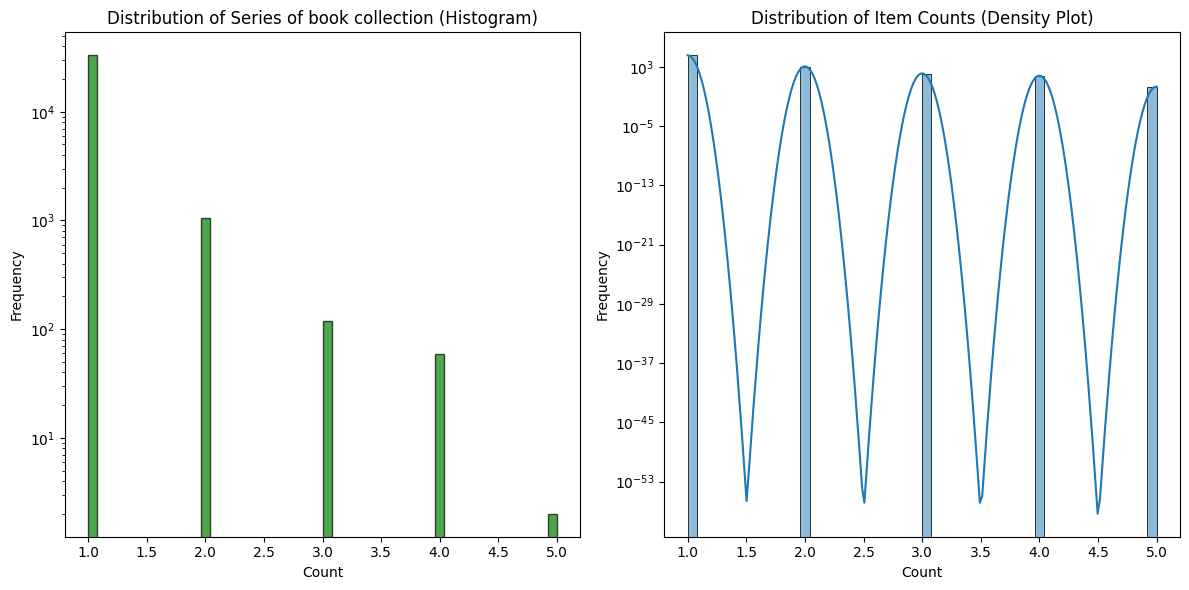

In [38]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the count data
count_data = books_with_length.select('series_length')
# Convert to pandas for plotting (or extract to numpy array)
counts = count_data['series_length'].to_numpy()

# Create the distribution plot
plt.figure(figsize=(12, 6))

# Option 1: Histogram
plt.subplot(1, 2, 1)
plt.hist(counts, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Series of book collection (Histogram)')
plt.yscale('log')  # Log scale for better visualization

# Option 2: Density plot using seaborn
plt.subplot(1, 2, 2)
sns.histplot(counts, kde=True, bins=50)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Item Counts (Density Plot)')
plt.yscale('log')

plt.tight_layout()
plt.show()

Большинство книг односерийные, абсолютное меньшинство и максимум - 5 книг

In [39]:
print(books_with_length.select([
    pl.col('series_length').min().alias('min_series_len'),
    pl.col('series_length').max().alias('max_series_len'),
]))

shape: (1, 2)
┌────────────────┬────────────────┐
│ min_series_len ┆ max_series_len │
│ ---            ┆ ---            │
│ u64            ┆ u64            │
╞════════════════╪════════════════╡
│ 1              ┆ 5              │
└────────────────┴────────────────┘


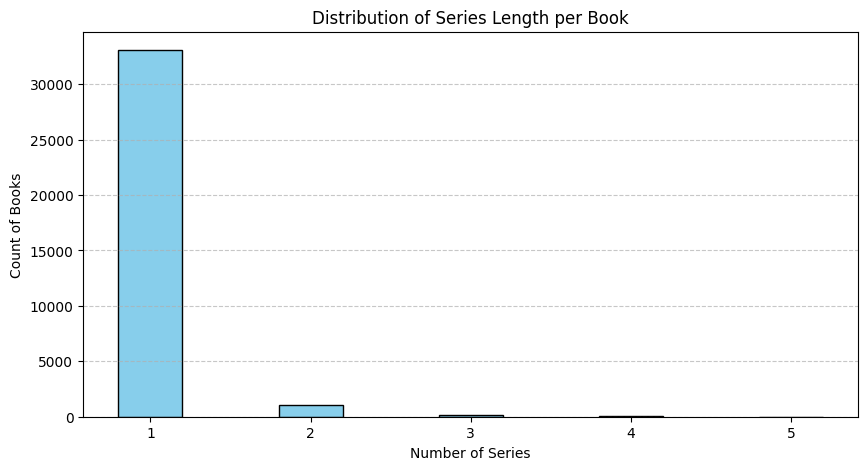

In [40]:
# Compute histogram bins for series_length
series_bins = books_with_length.group_by(
    pl.col('series_length').cast(pl.Int32)
).agg(
    count=pl.len()
).sort('series_length')

# Plot series_length histogram
plt.figure(figsize=(10, 5))
plt.bar(series_bins['series_length'], series_bins['count'], width=0.4, color='skyblue', edgecolor='black')
plt.title('Distribution of Series Length per Book')
plt.xlabel('Number of Series')
plt.ylabel('Count of Books')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Compute histogram bins for authors_length (log scale for y due to max=52)


Здесь разница по количеству книг в серии видна еще более явно

Unique series IDs: 15311
shape: (10, 2)
┌───────────┬────────────┐
│ series_id ┆ book_count │
│ ---       ┆ ---        │
│ str       ┆ u64        │
╞═══════════╪════════════╡
│ null      ┆ 15054      │
│ 302699    ┆ 13         │
│ 145914    ┆ 10         │
│ 154566    ┆ 10         │
│ 207337    ┆ 9          │
│ 152000    ┆ 9          │
│ 164397    ┆ 8          │
│ 935463    ┆ 8          │
│ 205443    ┆ 8          │
│ 152997    ┆ 7          │
└───────────┴────────────┘


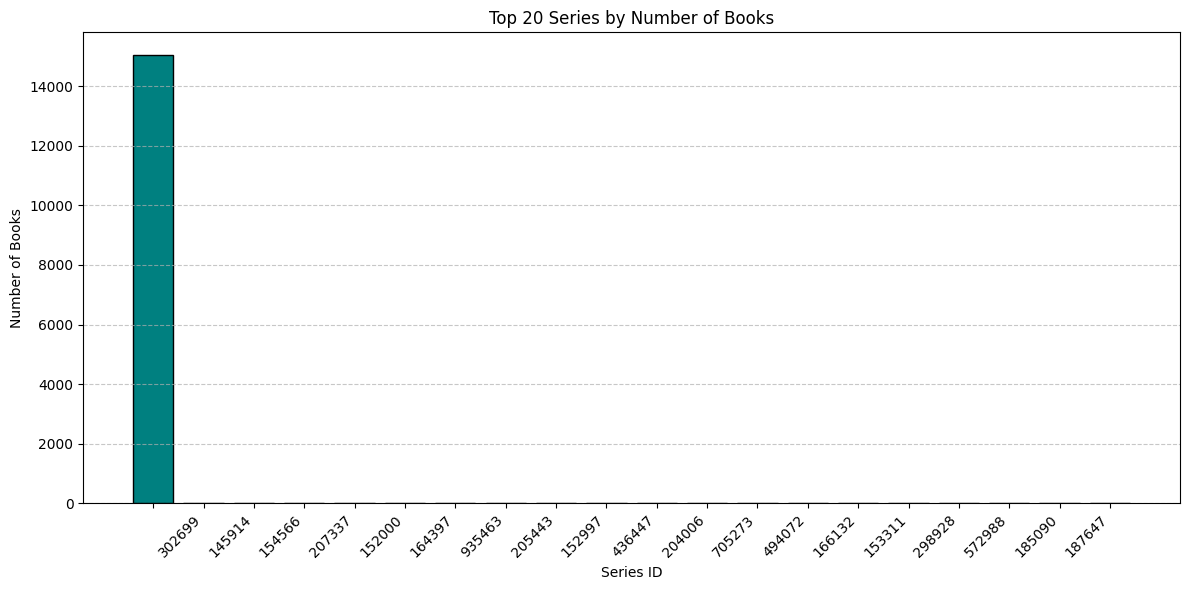

In [41]:
# Explode series and compute frequencies
series_freq = (
    books_with_length.select(pl.col('series').explode().alias('series_id'))
    .group_by('series_id')
    .agg(book_count=pl.len())
    .sort('book_count', descending=True)
)
print(f"Unique series IDs: {series_freq.shape[0]}")
print(series_freq.head(10))  # Top 10 for inspection

# Prepare top 20 for plotting
top_series = series_freq.head(20)

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_series)), top_series['book_count'], color='teal', edgecolor='black')
plt.xticks(range(len(top_series)), top_series['series_id'], rotation=45, ha='right')
plt.title('Top 20 Series by Number of Books')
plt.xlabel('Series ID')
plt.ylabel('Number of Books')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Unique series IDs (excluding null): 15310
shape: (10, 2)
┌───────────┬────────────┐
│ series_id ┆ book_count │
│ ---       ┆ ---        │
│ str       ┆ u64        │
╞═══════════╪════════════╡
│ 302699    ┆ 13         │
│ 145914    ┆ 10         │
│ 154566    ┆ 10         │
│ 207337    ┆ 9          │
│ 152000    ┆ 9          │
│ 935463    ┆ 8          │
│ 205443    ┆ 8          │
│ 164397    ┆ 8          │
│ 436447    ┆ 7          │
│ 204006    ┆ 7          │
└───────────┴────────────┘


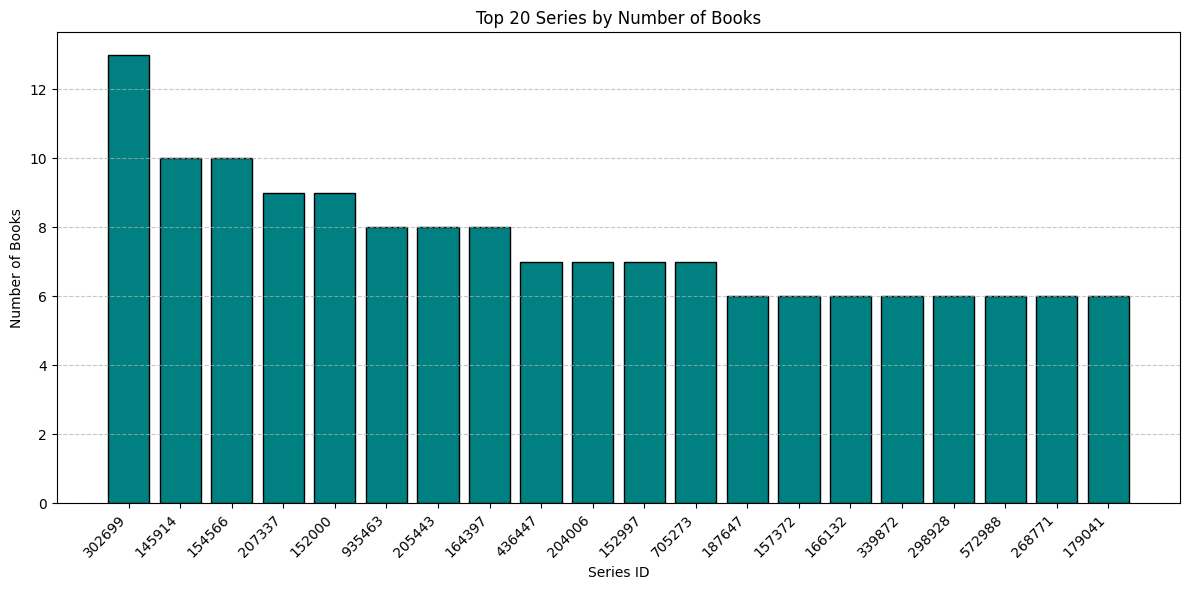

In [42]:
# Explode series and compute frequencies, excluding null values
series_freq = (
    books_with_length
    .select(pl.col('series').explode().alias('series_id'))
    .filter(pl.col('series_id').is_not_null())  # Exclude null values
    .group_by('series_id')
    .agg(book_count=pl.len())
    .sort('book_count', descending=True)
)

print(f"Unique series IDs (excluding null): {series_freq.shape[0]}")
print(series_freq.head(10))  # Top 10 for inspection

# Prepare top 20 for plotting (now without nulls)
top_series = series_freq.head(20)

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_series)), top_series['book_count'], color='teal', edgecolor='black')
plt.xticks(range(len(top_series)), top_series['series_id'], rotation=45, ha='right')
plt.title('Top 20 Series by Number of Books')
plt.xlabel('Series ID')
plt.ylabel('Number of Books')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### authors

In [43]:
books_with_length = books_with_length.with_columns(
    pl.col('authors').list.len().alias('authors_length')
)
books_with_length

item_id,series,tags,title,description,url,image_url,authors,series_length,authors_length
i64,list[str],list[str],str,str,str,str,list[struct[2]],u64,u64
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]",1,1
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]",1,1
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]",1,1
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]",1,1
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]",1,1
…,…,…,…,…,…,…,…,…,…
34317,"[""849421""]","[""will-never-read"", ""action"", … ""fiction""]","""The Cruelty (The Cruelty, #1)""","""When her diplomat father is ki…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14713542"",""""}]",1,1
34318,"[""795937""]","[""haven-t-bothered-to-finish"", ""library"", … ""favorites""]","""Does Snogging Count as Exercis…","""As one of the only girls in Ye…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""753459"",""""}]",1,1
34319,"[""921523""]","[""young-adult"", ""200-299-pgs"", … ""i-don-t-know""]","""Discovery (The Gifted, #1)""","""All twenty-three year old Kate…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""14590184"",""""}]",1,1


In [44]:
print(books_with_length.select([
    pl.col('authors_length').min().alias('min_authors_len'),
    pl.col('authors_length').max().alias('max_authors_len')
]))

shape: (1, 2)
┌─────────────────┬─────────────────┐
│ min_authors_len ┆ max_authors_len │
│ ---             ┆ ---             │
│ u64             ┆ u64             │
╞═════════════════╪═════════════════╡
│ 1               ┆ 52              │
└─────────────────┴─────────────────┘


In [45]:
books_with_length.sort(by='authors_length')

item_id,series,tags,title,description,url,image_url,authors,series_length,authors_length
i64,list[str],list[str],str,str,str,str,list[struct[2]],u64,u64
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]",1,1
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]",1,1
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]",1,1
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]",1,1
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]",1,1
…,…,…,…,…,…,…,…,…,…
10189,"[""824965"", ""824968"", … null]","[""you-should-get-it"", ""read-2012"", … ""2018-tbr""]","""After""","""If the melt-down, flood, plagu…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4018722"",""Contributor""}, {""58011"",""Contributor""}, … {""19305"",""""}]",4,46
2088,[null],"[""china"", ""japan-japanese"", … ""to-buy""]","""Tomo: Friendship through Ficti…","""This aptly named fiction antho…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""6583722"",""Contributor""}, {""68794"",""Contributor""}, … {""495801"",""Illustrator""}]",1,48
17016,[null],"[""bc1"", ""anthology"", … ""novellas-inspiration""]","""Horror Stories""","""Perfect for Halloween -- a chi…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4953"",""Contributor""}, {""209"",""""}, … {""115840"",""Contributor""}]",1,49


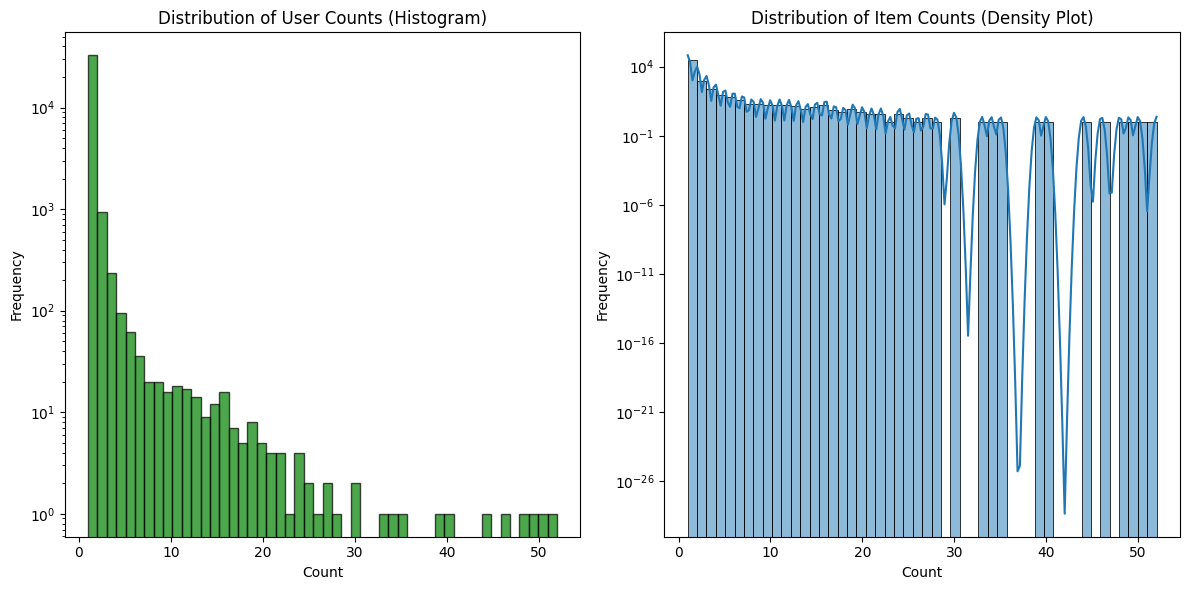

In [46]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the count data
count_data = books_with_length.select('authors_length')
# Convert to pandas for plotting (or extract to numpy array)
counts = count_data['authors_length'].to_numpy()

# Create the distribution plot
plt.figure(figsize=(12, 6))

# Option 1: Histogram
plt.subplot(1, 2, 1)
plt.hist(counts, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of User Counts (Histogram)')
plt.yscale('log')  # Log scale for better visualization

# Option 2: Density plot using seaborn
plt.subplot(1, 2, 2)
sns.histplot(counts, kde=True, bins=50)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Item Counts (Density Plot)')
plt.yscale('log')

plt.tight_layout()
plt.show()

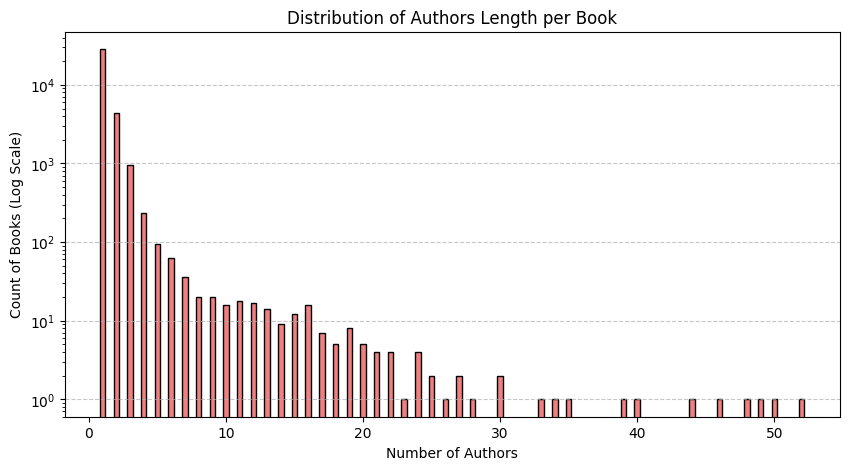

In [47]:
authors_bins = books_with_length.group_by(
    pl.col('authors_length').cast(pl.Int32)
).agg(
    count=pl.len()
).sort('authors_length')

# Plot authors_length histogram (log y-axis for long tail)
plt.figure(figsize=(10, 5))
plt.bar(authors_bins['authors_length'], authors_bins['count'], width=0.4, color='lightcoral', edgecolor='black')
plt.yscale('log')  # Log scale for y-axis
plt.title('Distribution of Authors Length per Book')
plt.xlabel('Number of Authors')
plt.ylabel('Count of Books (Log Scale)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

Также глядя на расспределение количества авторов видим что в большинстве случаев автор один


In [49]:
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

# Inspect the schema of the authors struct
print(books_with_length['authors'].head(1).list.first().struct.schema)

Schema([('author_id', String), ('role', String)])


In [50]:
# Confirm DataFrame size
print(f"DataFrame shape: {books_with_length.shape}")

# Check for empty or null authors lists
print(books_with_length.select([
    pl.col('authors').is_null().sum().alias('null_authors'),
    pl.col('authors').list.len().eq(0).sum().alias('empty_authors'),
    pl.col('authors').list.len().max().alias('max_authors_length')
]))

DataFrame shape: (34322, 10)
shape: (1, 3)
┌──────────────┬───────────────┬────────────────────┐
│ null_authors ┆ empty_authors ┆ max_authors_length │
│ ---          ┆ ---           ┆ ---                │
│ u64          ┆ u64           ┆ u64                │
╞══════════════╪═══════════════╪════════════════════╡
│ 0            ┆ 0             ┆ 52                 │
└──────────────┴───────────────┴────────────────────┘


Обошлись без безымянных книг)

In [51]:
# Create a DataFrame with exploded authors
authors_exploded = books_with_length.select([
    pl.col('item_id'),
    pl.col('authors').list.eval(
        pl.struct(
            pl.element().struct.field('author_id').alias('author_id'),
            pl.element().struct.field('role').alias('role')
        )
    ).alias('author_info')
]).explode('author_info').unnest('author_info')

# Verify
print(authors_exploded.head(5))
print(f"Total author entries: {authors_exploded.shape[0]}")

shape: (5, 3)
┌─────────┬───────────┬──────┐
│ item_id ┆ author_id ┆ role │
│ ---     ┆ ---       ┆ ---  │
│ i64     ┆ str       ┆ str  │
╞═════════╪═══════════╪══════╡
│ 0       ┆ 1879494   ┆      │
│ 1       ┆ 21740     ┆      │
│ 2       ┆ 18946     ┆      │
│ 3       ┆ 4605      ┆      │
│ 4       ┆ 792676    ┆      │
└─────────┴───────────┴──────┘
Total author entries: 45058


Есть топ 5 самых популярных авторов

In [52]:
authors_exploded

item_id,author_id,role
i64,str,str
0,"""1879494""",""""""
1,"""21740""",""""""
2,"""18946""",""""""
3,"""4605""",""""""
4,"""792676""",""""""
…,…,…
34317,"""14713542""",""""""
34318,"""753459""",""""""
34319,"""14590184""",""""""


Фича авторы (как видно смотря на словари здесь не только авторы, но и продюссеры, консультанты и тд) Очень сомнительная информативность фичи.

#### title

In [ ]:
import polars as pl

# Get the most popular items (top 10 as an example)
top_items = (train
             .group_by('item_id')
             .agg(pl.count().alias('count'))
             .sort(by='count', descending=True)
             .head(10))

# Join with books DataFrame to get the descriptions
popular_books_with_info = (top_items
                          .join(books_cleaned, on='item_id', how='left')
                          .select(['item_id', 'count', 'title', 'authors', 'description']))

# Display the results
print(popular_books_with_info)



shape: (10, 5)
┌─────────┬───────┬──────────────────────────┬──────────────────────────┬──────────────────────────┐
│ item_id ┆ count ┆ title                    ┆ authors                  ┆ description              │
│ ---     ┆ ---   ┆ ---                      ┆ ---                      ┆ ---                      │
│ i64     ┆ u64   ┆ str                      ┆ list[struct[2]]          ┆ str                      │
╞═════════╪═══════╪══════════════════════════╪══════════════════════════╪══════════════════════════╡
│ 4058    ┆ 91558 ┆ The Fault in Our Stars   ┆ [{"3164289","Narrator"}, ┆ Despite the              │
│         ┆       ┆                          ┆ {"140…                   ┆ tumour-shrinking m…      │
│ 15514   ┆ 88038 ┆ The Hunger Games (The    ┆ [{"153394",""},          ┆ Winning will make you    │
│         ┆       ┆ Hunger G…                ┆ {"899110","Nar…          ┆ famous.                  │
│         ┆       ┆                          ┆                          ┆ … 

/tmp/ipykernel_1960/3757600577.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias('count'))


In [55]:
popular_books_with_info.select('title').head(20)

title
str
"""The Fault in Our Stars"""
"""The Hunger Games (The Hunger G…"
"""Divergent (Divergent, #1)"""
"""Red Queen (Red Queen, #1)"""
"""Eleanor & Park"""
"""We Were Liars"""
"""Catching Fire (The Hunger Game…"
"""Cinder (The Lunar Chronicles, …"
"""Mockingjay (The Hunger Games, …"


#### tags

/tmp/ipykernel_1960/4196636856.py:20: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  .filter(pl.col('tags').is_in(common_tags))


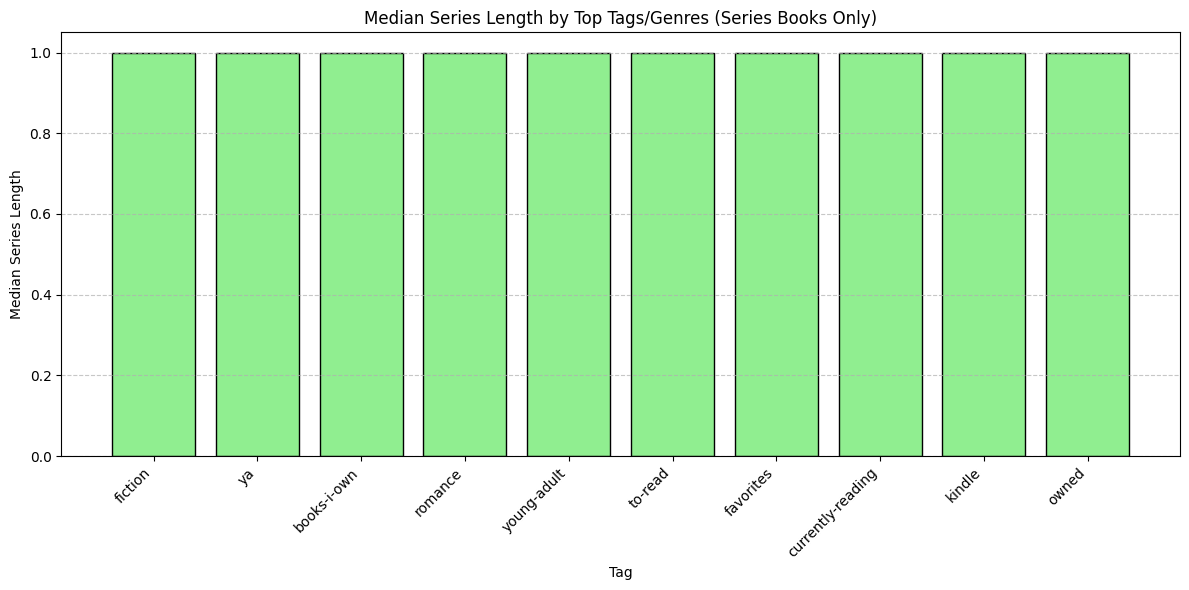

In [57]:
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

# Filter for books with series_length > 0
df_series = books_with_length.filter(pl.col('series_length') > 0)

# Get top 10 tags by frequency, filtered to include series-related tags if possible
common_tags = (
    df_series.select(pl.col('tags').explode().alias('tag'))
    .group_by('tag')
    .agg(count=pl.len())
    .sort('count', descending=True)
    .head(10)
)['tag']

# Compute median series_length per tag
tag_series_length = (
    df_series.explode('tags')
    .filter(pl.col('tags').is_in(common_tags))
    .group_by('tags')
    .agg(median_length=pl.col('series_length').median())
    .sort('median_length', descending=True)
)

# Bar chart of median series_length by tag
plt.figure(figsize=(12, 6))
plt.bar(range(len(tag_series_length)), tag_series_length['median_length'], color='lightgreen', edgecolor='black')
plt.xticks(range(len(tag_series_length)), tag_series_length['tags'], rotation=45, ha='right')
plt.title('Median Series Length by Top Tags/Genres (Series Books Only)')
plt.xlabel('Tag')
plt.ylabel('Median Series Length')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optional: Log scale if median lengths vary widely
if tag_series_length['median_length'].max() > 10:  # Adjust threshold as needed
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(tag_series_length)), tag_series_length['median_length'], color='lightgreen', edgecolor='black')
    plt.yscale('log')
    plt.xticks(range(len(tag_series_length)), tag_series_length['tags'], rotation=45, ha='right')
    plt.title('Median Series Length by Top Tags/Genres (Log Scale, Series Books Only)')
    plt.xlabel('Tag')
    plt.ylabel('Median Series Length (Log Scale)')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

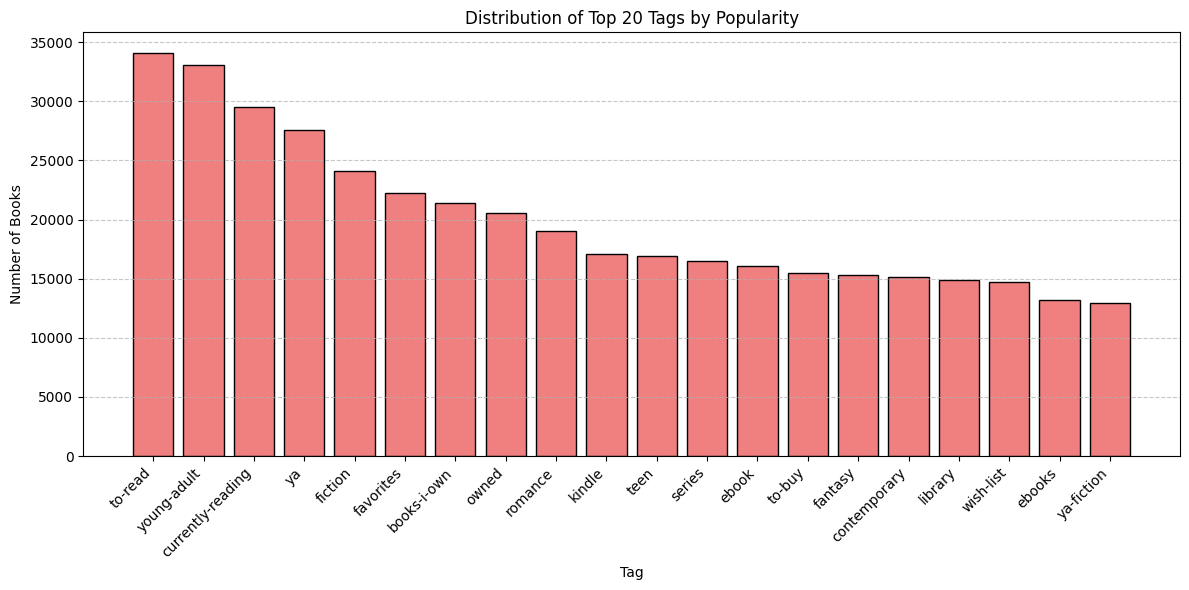

shape: (20, 2)
┌───────────────────┬───────┐
│ tag               ┆ count │
│ ---               ┆ ---   │
│ str               ┆ u64   │
╞═══════════════════╪═══════╡
│ to-read           ┆ 34125 │
│ young-adult       ┆ 33110 │
│ currently-reading ┆ 29492 │
│ ya                ┆ 27595 │
│ fiction           ┆ 24100 │
│ …                 ┆ …     │
│ contemporary      ┆ 15121 │
│ library           ┆ 14862 │
│ wish-list         ┆ 14744 │
│ ebooks            ┆ 13175 │
│ ya-fiction        ┆ 12920 │
└───────────────────┴───────┘


In [58]:
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

# Compute tag frequencies
tag_freq = (
    books_with_length.select(pl.col('tags').explode().alias('tag'))
    .group_by('tag')
    .agg(count=pl.len())
    .sort('count', descending=True)
)

# Select top 20 tags for visualization
top_tags = tag_freq.head(20)

# Bar chart of tag popularity
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_tags)), top_tags['count'], color='lightcoral', edgecolor='black')
plt.xticks(range(len(top_tags)), top_tags['tag'], rotation=45, ha='right')
plt.title('Distribution of Top 20 Tags by Popularity')
plt.xlabel('Tag')
plt.ylabel('Number of Books')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optional: Print top 20 tags with counts for reference
print(top_tags)

Чаасть тегов выражают жанр а часть нет

In [65]:

import polars as pl
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import re
from typing import List, Optional
from tqdm import tqdm

# Set seed for consistent results
DetectorFactory.seed = 0

def clean_text_for_detection(text: str) -> str:
    """Clean text to improve language detection"""
    if not isinstance(text, str):
        return ""
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text.strip())
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove numbers and special characters if text is mostly non-alphabetic
    if len(re.sub(r'[^a-zA-Zа-яА-Я]', '', text)) < len(text) * 0.3:
        # If less than 30% alphabetic characters, remove numbers and special chars
        text = re.sub(r'[^a-zA-Zа-яА-Я\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text.strip())
    
    return text

def detect_single_language(text: str, min_length: int = 10) -> str:
    """Detect language of a single text with error handling"""
    if not isinstance(text, str) or not text:
        return "unknown"
    
    # Clean the text
    cleaned_text = clean_text_for_detection(text)
    
    # Check if text is too short or empty after cleaning
    if len(cleaned_text) < min_length:
        return "too_short"
    
    # Check if text contains enough alphabetic characters
    alpha_chars = re.sub(r'[^a-zA-Zа-яА-Я]', '', cleaned_text)
    if len(alpha_chars) < 5:  # Need at least 5 letters
        return "insufficient_text"
    
    try:
        detected_lang = detect(cleaned_text)
        return detected_lang
    except LangDetectException as e:
        # Handle specific langdetect errors
        if "No features in text" in str(e):
            return "no_features"
        elif "Can't detect" in str(e):
            return "undetectable"
        else:
            return "error"
    except Exception as e:
        return "error"


def detect_languages_robust(texts: List[str], 
                          show_progress: bool = True,
                          min_length: int = 10,
                          batch_size: int = 1000) -> List[str]:
    """
    Robust language detection with progress bar and batch processing
    
    Args:
        texts: List of texts to analyze
        show_progress: Whether to show progress bar
        min_length: Minimum text length to attempt detection
        batch_size: Process in batches to avoid memory issues
    
    Returns:
        List of detected languages
    """
    if not texts:
        return []
    
    languages = []
    
    # Process in batches
    total_batches = len(texts) // batch_size + (1 if len(texts) % batch_size != 0 else 0)
    
    if show_progress:
        pbar = tqdm(total=len(texts), desc="Detecting languages")
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batch_languages = []
        
        for text in batch:
            lang = detect_single_language(text, min_length)
            batch_languages.append(lang)
            
            if show_progress:
                pbar.update(1)
        
        languages.extend(batch_languages)
    
    if show_progress:
        pbar.close()
    
    return languages


def detect_languages_with_polars(df: pl.DataFrame, 
                                text_column: str = 'description',
                                output_column: str = 'detected_language') -> pl.DataFrame:
    """
    Detect languages directly with Polars integration
    
    Args:
        df: Polars DataFrame
        text_column: Name of column containing text
        output_column: Name of output column for detected languages
    
    Returns:
        DataFrame with added language column
    """
    # Extract texts as list
    texts = df.select(text_column).to_series().to_list()
    
    # Detect languages
    languages = detect_languages_robust(texts)
    
    # Add to DataFrame
    result_df = df.with_columns(
        pl.Series(output_column, languages)
    )
    
    return result_df


books_with_languages = detect_languages_with_polars(books, 'description', 'language')
    

Detecting languages: 100%|██████████| 34322/34322 [02:26<00:00, 233.56it/s]


In [69]:
books_with_languages.select('language').to_series().value_counts().sort(by='count', descending=True)

language,count
str,u64
"""en""",32662
"""unknown""",1635
"""too_short""",9
"""de""",3
"""id""",2
…,…
"""tl""",1
"""fr""",1
"""cy""",1


Как видно подавляющее побольшинство книг на английском. Но Чтобы делать рекомендации для всех юзеров и чтобы продвигать в том числе непопулярные товары то нам нужно учитывать другой язык, поэтому нужно брать мультиязычный текстовый энкодер. 